In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read Training Set
df = pd.read_csv('train.csv',dtype={
                             'ip': np.uint8,
                             'app': np.uint8,
                             'device' : np.uint8,
                             'os' : np.uint8,
                             'channel' : np.uint8,
                             'is_attributed' : np.uint8    
                        },parse_dates=['click_time'])

In [3]:
df['day'] = df['click_time'].dt.day.astype('uint8')
# Sample Data
df = df[df['day']==7]

In [4]:
df['hour'] = df['click_time'].dt.hour.astype('uint8')
df['minute'] = df['click_time'].dt.minute.astype('uint8')
df['second'] = df['click_time'].dt.second.astype('uint8')

#Edit minute variable to two-digit string
df['minute'] = df['minute'].apply(lambda x: '{0:0>2}'.format(x))

In [5]:
ranges = [-1, 4, 9, 14, 19, 24, 29, 34, 39, 44, 49, 54, np.inf]  # np.inf for infinity
labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
df['seconds_grp'] = pd.cut(df['second'], 
                                  bins=ranges, 
                                  labels=labels)
df['interval'] = df['hour'].astype(str) + df['minute'].astype(str) + df['seconds_grp'].astype(str)
#df['interval'] = df['interval'].astype('uint32')

df.sample(5)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second,seconds_grp,interval
12015416,191,3,1,3,123,2017-11-07 00:44:42,NaN,0,7,0,44,42,9,0449
35978860,229,3,1,25,135,2017-11-07 08:14:51,NaN,0,7,8,14,51,11,81411
17179375,26,64,1,41,203,2017-11-07 02:18:11,NaN,0,7,2,18,11,3,2183
42689690,0,9,1,20,78,2017-11-07 10:31:06,NaN,0,7,10,31,6,2,10312
58343432,224,12,1,19,72,2017-11-07 15:29:58,NaN,0,7,15,29,58,12,152912


In [6]:
df_interval = df.groupby(
    'interval'
).aggregate(
    {
        'is_attributed':sum,
        'click_time':"count"
    }
).rename(
    columns = {
        'is_attributed': 'total_dl', 
        'click_time': 'total_clicks'
    }, 
    inplace = False)
df_interval.sample(5)

,total_dl,total_clicks
interval,,
3272,8,4266
3021,29,4182
12599,9,4100
2579,15,4368
18411,2,919


In [7]:
df_interval['conversion_rate'] = df_interval['total_dl']/df_interval['total_clicks']
df_interval['ratio'] = df_interval['total_clicks']/df_interval['total_dl']
df_interval.reset_index(level=0, inplace=True)
df_interval.head()

,interval,total_dl,total_clicks,conversion_rate,ratio
0,0001,9,3831,0.002349,425.666667
1,00010,5,4607,0.001085,921.400000
2,00011,4,4834,0.000827,1208.500000
3,00012,7,4812,0.001455,687.428571
4,0002,4,4767,0.000839,1191.750000


In [8]:
df_interval.dtypes

interval            object
total_dl             uint8
total_clicks         int64
conversion_rate    float64
ratio              float64
dtype: object

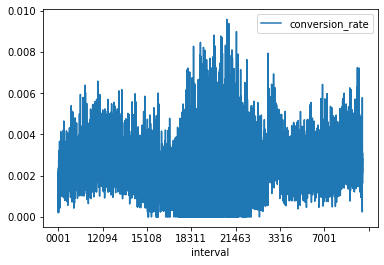

In [9]:
df_interval.plot(x ='interval', y='conversion_rate', kind = 'line')
plt.show()

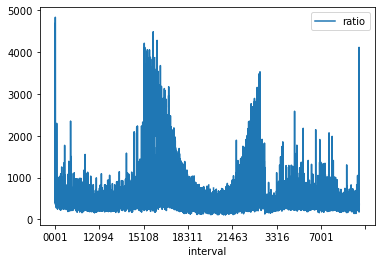

In [10]:
df_interval.plot(x ='interval', y='ratio', kind = 'line')
plt.show()

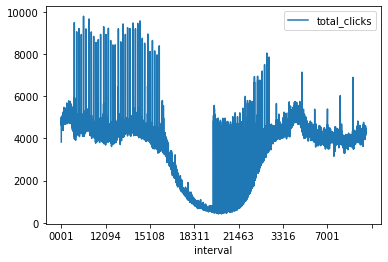

In [11]:
df_interval.plot(x ='interval', y='total_clicks', kind = 'line')
plt.show()

In [12]:
#threshold for fraud total clicks
co = df_interval[df_interval['conversion_rate']==0]
Q1 = co.total_clicks.quantile(0.25)
Q3 = co.total_clicks.quantile(0.75)
IQR = Q3 - Q1
click_outlier = Q3 + 1.5 * IQR
print(click_outlier)

1250.0


In [13]:
#threshold for fraud total clicks
ro = df_interval[df_interval['conversion_rate']!=0]
Q1 = ro.ratio.quantile(0.25)
Q3 = ro.ratio.quantile(0.75)
IQR = Q3 - Q1
ratio_outlier = Q3 + 1.5 * IQR
print(ratio_outlier)

939.8804563492063


In [14]:
# apply to df_interval
df_interval.loc[(df_interval['total_dl'] == 0) & (df_interval['total_clicks'] > click_outlier), 'isFraud'] = 1
df_interval.loc[(df_interval['total_dl'] != 0) & (df_interval['ratio'] > ratio_outlier), 'isFraud'] = 1
df_interval.loc[(df_interval['isFraud'].isnull()), 'isFraud'] = 0

# event rate on df_interval
df_interval.isFraud.sum()/len(df_interval)

0.06474358974358975

In [15]:
# apply to df
df = pd.merge(df, df_interval[['interval', 'isFraud']], on='interval', how='left')

# event rate on df
df.isFraud.sum()/len(df)

0.05613631039430815